In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# If you use google colab, make sure to mount your drive before proceed
from google.colab import drive
# Mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Preprocessing

## 📥 Steps Involved:

- **Loading the dataset**  
- **Rescaling pixel values** to be between 0 and 1  
- **Splitting the dataset** into training, validation, and test sets


In [2]:
# Load the MNIST dataset
df = pd.read_csv("./dataset/mnist_digits.csv") # Path to your MNIST dataset

print(df.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

### 📄 Dataset Structure

- The **first column** in the table represents the **true label** (or target) of the image.
- Since this dataset contains **handwritten digits**, the labels range from **0 to 9**.
- The **remaining 784 columns** represent the **individual pixel values** of a **28x28 grayscale image**.
- Each **row corresponds to a single image**, meaning the dataset with **42,000 rows contains 42,000 images** in total.


In [3]:
# Seperating the labels or targets from the image's pixels
targets = df["label"].values # Getting the label and store it in a variable
pixels = df.drop("label", axis=1).values # Dropping the label column and storing only the pixels

print(targets)
print(f"There are {len(targets)} images in this dataset")

[1 0 1 ... 7 6 9]
There are 42000 images in this dataset


In [4]:
# Rescale pixel values to the range 0-1
pixels = pixels / 255.0 # Image pixel ranges from 0-255

# Reshape the images to 28x28 for visualization and CNN input
pixels = pixels.reshape(-1, 28, 28, 1)  # re-arrange each rows (each pixel) in the dataset into a 2 dimensional array of size 28x28 and 1 channel (grayscale)

print(f"Dataset shape: {pixels.shape}, Labels shape: {targets.shape}")

Dataset shape: (42000, 28, 28, 1), Labels shape: (42000,)


### 🖼️ Image Dimensions and Channels

- **42,000** refers to the **total number of images** in the dataset.
- Each image has a shape of **(28, 28, 1)**:
  - `28 x 28` represents the **height and width** in pixels.
  - `1` refers to the **number of channels** — since the images are **grayscale**, there is only **one channel**.


In [5]:
# Splitting the dataset into 70% training, 20% testing and 10% validation
X_train, X_test, y_train, y_test = train_test_split(pixels, targets, test_size=0.2, random_state=123) # random_state allow us to reproduce the exact split again
X_train, X_val, y_train, y_val = train_test_split(pixels, targets, test_size=(1/8), random_state=123) # 1/8 of 80% is 10% of the overall dataset

# Check how much images are in each sets
print("Training set:", len(y_train))
print("Validation set:",  len(y_val))
print("Testing set:", len(y_test))

Training set: 36750
Validation set: 5250
Testing set: 8400


### 📊 Dataset Split

After splitting the dataset, we have:

- **36,750 images** for **training**
- **8,400 images** for **testing**
- **5,250 images** for **validation**


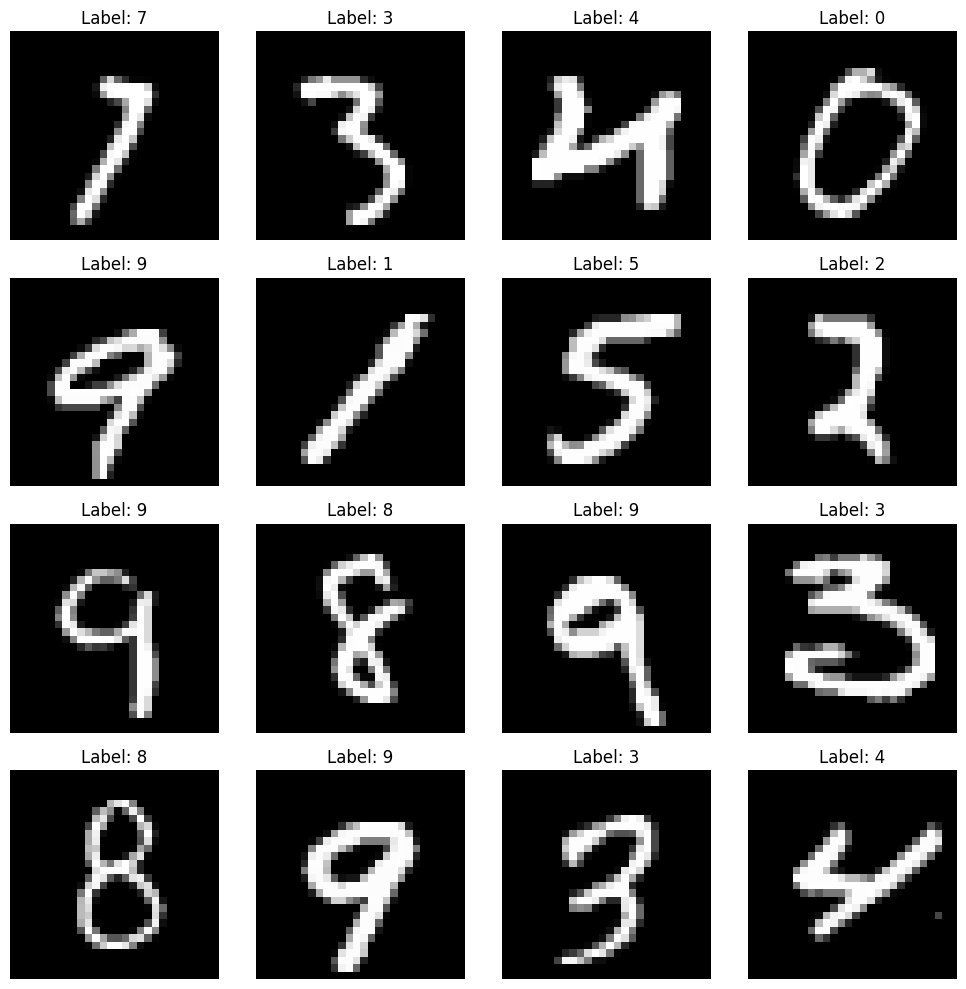

In [8]:
# Plot some images
plt.figure(figsize=(10, 10))  # Set the figure size
for i in range(16):  # Plot the first 16 images
    plt.subplot(4, 4, i + 1)  # Create 4x4 grid to plot the images
    plt.imshow(X_train[i], cmap="gray")  # Display the image in grayscale
    plt.title(f"Label: {y_train[i]}")  # Add the label as the title
    plt.axis("off")  # Turn off axis

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# 2. 🏗️ Building Modified LeNet-5

### 🧠 About LeNet-5

**LeNet-5**, introduced by **Yann LeCun in 1998**, is one of the earliest and most influential convolutional neural network (CNN) architectures. It was specifically designed for **handwritten digit recognition** tasks, such as those involving the **MNIST dataset**.

### 📌 Key Characteristics:

- **Compact and efficient** architecture
- Combines:
  - **Convolutional layers** for feature extraction
  - **Fully connected layers** for classification
- Served as the **foundation for modern deep learning architectures**
- Demonstrated the **effectiveness of CNNs** in solving image classification problems

### 🛠️ In This Project:

We implement a **modified version of LeNet-5**, tailored for our dataset, preserving the original model’s strengths while adapting it for modern frameworks and data.


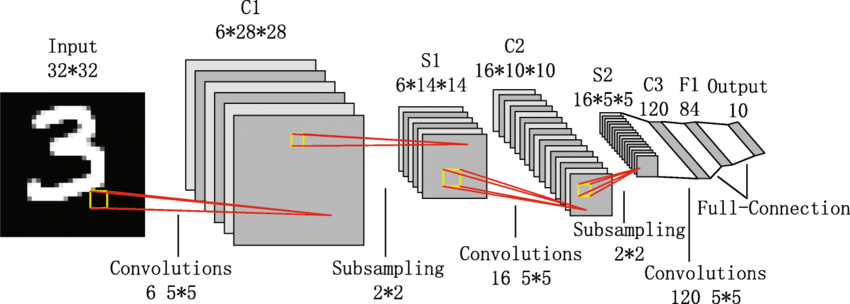

### 🔧 Modified LeNet-5 Architecture

For the purpose of our study, we **replace LeNet-5's subsampling layers with average pooling layers**, due to their functional similarity.  
At the time LeNet-5 was created, pooling layers had not yet been formally introduced, so **subsampling** was used to reduce the feature map size.

---

## 🧱 Layer-by-Layer Breakdown of Modified LeNet-5

### 1. 📥 Input Layer
- **Input Size**: 28×28 (grayscale image)

### 2. 🧩 Convolutional Layer 1 (C1)
- **Filters**: 6 filters of size 5×5  
- **Padding**: None  
- **Stride**: 1  
- **Activation**: Tanh

### 3. 🔽 Average Pooling Layer 1 (S2)
- **Filter Size**: 2×2  
- **Stride**: 2

### 4. 🧩 Convolutional Layer 2 (C3)
- **Filters**: 16 filters of size 5×5  
- **Padding**: None  
- **Stride**: 1  
- **Activation**: Tanh

### 5. 🔽 Average Pooling Layer 2 (S4)
- **Filter Size**: 2×2  
- **Stride**: 2

### 6. 🧩 Convolutional Layer 3 (C5)
- **Input**: Output from Layer S4 — 16 feature maps of size 5×5  
- **Feature Maps**: 120  
- **Filter Size**: 4×4  
- **Activation**: Tanh

### 7. 🔌 Fully Connected Layer (F6)
- **Neurons**: 84  
- **Activation**: Tanh

### 8. 🎯 Output Layer
- **Neurons**: 10 (for digit classification: 0–9)  
- **Activation**: Softmax


In [17]:
def create_LeNet5(input_shape):
  model = models.Sequential([

      # C1 and inputs
      layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(input_shape), padding="valid", name="C1"),

      # S2 Average pooling
      layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), name="S2"),

      # C3
      layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="valid", name="C3"),

      #S4
      layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), name="S4"),

      #C5 (kernel size is smaller than original LeNet-5 in this layer because our images are smaller than what LeNet-5 was trained on)
      layers.Conv2D(filters=120, kernel_size=(4, 4), strides=(1, 1), activation='tanh', padding="valid", name="C5"),

      #F6
      layers.Flatten(name="Flatten"), # Convert all features map into 1D vector for fully connected layer to process

      layers.Dense(units=84, activation='tanh', name="F6"),
      # layers.Dropout(0.5, name="Dropout"), # Disable 50% of the neuron to avoid overfitting,

      # Output Layer
      layers.Dense(units=10, activation='softmax', name="Output") # Units=10 because there are 10 classes (0-9)

  ], name="modifiedLeNet5")
  return model

LeNet5 = create_LeNet5(input_shape=(28, 28, 1)) # (28, 28, 1) is the shape of our images

# Compile the model
# Experiment with these optimizer to see different results
SGD = SGD(learning_rate=0.001)  # Specify the learning rate
RMSprop = RMSprop(learning_rate=0.01)  # Specify the learning rate
Adam = Adam(learning_rate=0.0001)  # Specify the learning rate

# sparse categorical crossentropy is a common loss function for multi-class classification
LeNet5.compile(optimizer=SGD, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
LeNet5.summary()

Model: "modifiedLeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2 (AveragePooling2D)           │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4 (AveragePooling2D)           │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C5 (Conv2D)                     │ (None, 1, 1, 120)      │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,426 (173.54 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
BATCH_SIZE = 128 # Hyperparamters
EPOCHS = 100 # Hyperparameters

seed_value = 42 # Set seed to reproduce results during training

tf.random.set_seed(seed_value)
# Train the model
history = LeNet5.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                     shuffle=True)  # Validation data to evaluate performance during training

Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1644 - loss: 2.2956 - val_accuracy: 0.2737 - val_loss: 2.2721
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2998 - loss: 2.2630 - val_accuracy: 0.3606 - val_loss: 2.2337
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3902 - loss: 2.2213 - val_accuracy: 0.4566 - val_loss: 2.1791
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4879 - loss: 2.1605 - val_accuracy: 0.5322 - val_loss: 2.0955
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5508 - loss: 2.0673 - val_accuracy: 0.5760 - val_loss: 1.9694
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5931 - loss: 1.9298 - val_accuracy: 0.6107 - val_loss: 1.7991
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6202 - loss: 1.7522 - val_accuracy: 0.6415 - val_loss: 1.6072
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6552 - loss: 1.5605 - val_accu

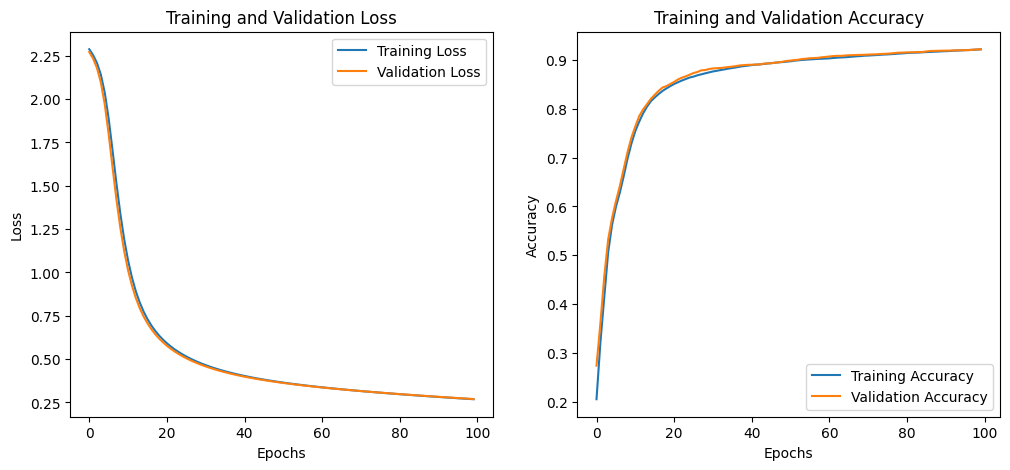

In [19]:
# Extract metrics
loss = history.history['loss'] # Getting the training loss history of training
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5)) # Define the size of the plot
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss') # plotting the training loss graph
plt.plot(val_loss, label='Validation Loss') # plotting the validation loss graph
plt.xlabel('Epochs') # plotting the labels
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy') # plotting the training accuracy graph
plt.plot(val_accuracy, label='Validation Accuracy') # plotting the validation accuracy graph
plt.xlabel('Epochs') # plotting the labels
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


### 📉 Model Performance and Convergence

Judging by the training and validation accuracy/loss graphs, the **LeNet-5 model converged nicely**, indicating that it successfully learned optimal weights and biases within the constraints of its architecture.

The model performed **exceptionally well on the training set**, which is expected as it was directly optimized on that data.

### ✅ Final Accuracy:

- **Training Accuracy**: 91.53%  
- **Validation Accuracy**: 91.98%

These results demonstrate that the model generalizes well and maintains strong performance across unseen validation data.


In [20]:
# Evaluating the final model on test set
test_loss, test_accuracy = LeNet5.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9207 - loss: 0.2716
Test Loss: 0.26522839069366455
Test Accuracy: 0.9245238304138184


### 🧪 Final Evaluation

The **LeNet-5 model** achieved an **accuracy of 92.02%** on the test dataset, with a **loss of 0.2711**.

This indicates strong performance and a good balance between bias and variance.


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


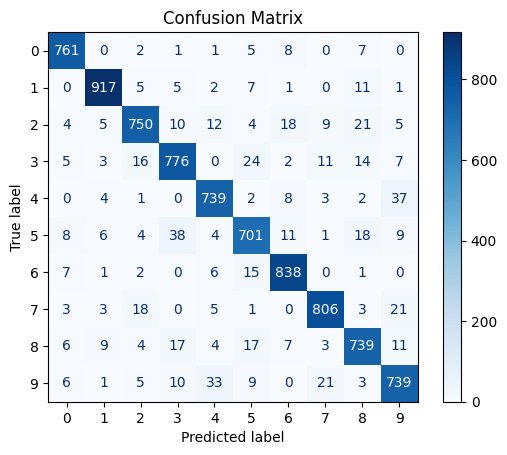

In [21]:
# Predict class labels for the test set
predicted_classes = np.argmax(LeNet5.predict(X_test), axis=1)
true_classes = y_test

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))  # Assuming classes 0-9
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

### 📊 Confusion Matrix Interpretation

- **Rows** represent the **actual labels** (true classes).
- **Columns** represent the **predicted labels** (model outputs).
- **Each cell** indicates the number of instances that fall into the corresponding combination of actual and predicted classes.


In [22]:
# Select a few test samples
num_samples = 10  # Number of samples to visualize
indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

# Get the selected images and true labels
sample_images = X_test[indices]
sample_true_labels = y_test[indices]

 # Get predictions
sample_predictions = np.argmax(LeNet5.predict(sample_images), axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


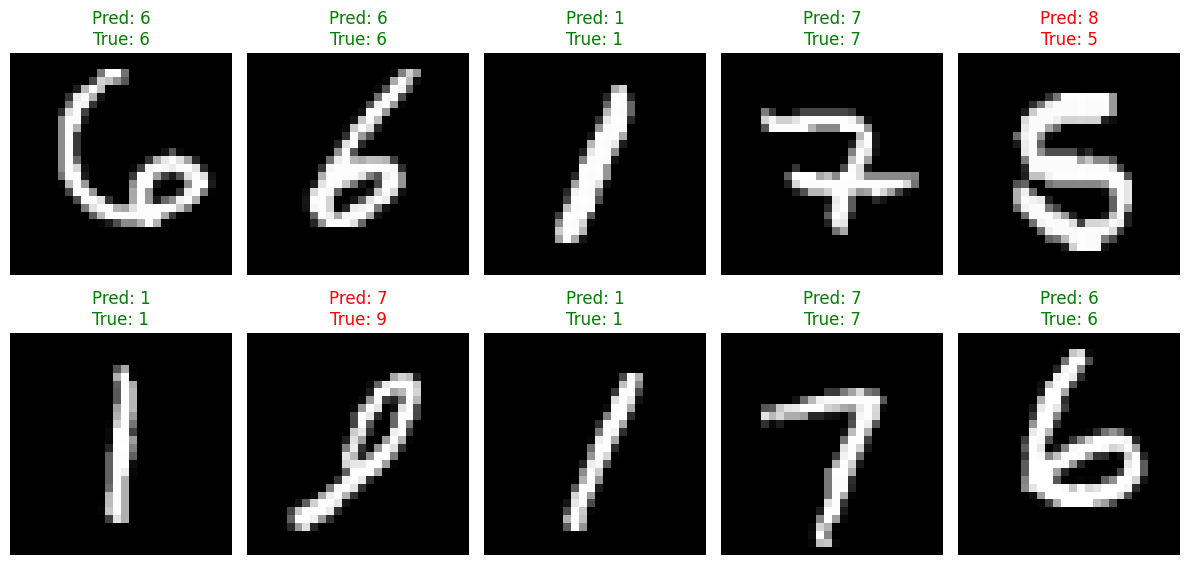

In [23]:
# Plot the images with predicted and true labels
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)  # Create a grid of 2 rows, 5 columns
    plt.imshow(sample_images[i].squeeze(), cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    color = "green" if sample_predictions[i] == sample_true_labels[i] else "red"
    plt.title(f"Pred: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=color)
plt.tight_layout()
plt.show()

In [24]:
# Saving the model, which we can use and apply it on other application
LeNet5.save("lenet5_weights.h5")


### Appendix

In [ ]:
# Data augmentation code using tensorflow
"""
  Why data augmentation is needed:
    --Increases Dataset Size: Expands small datasets, reducing overfitting.
    --Improves Generalization: Makes the model more robust to variations (e.g., rotation, lighting).
    --Prevents Overfitting: Encourages the model to focus on general patterns, not specifics.
    --Simulates Real-World Variations: Exposes the model to different conditions.
    --Boosts Performance with Limited Data: Useful when datasets are small.
    --Improves Convergence: Helps the model converge faster by presenting diverse data.
"""
import tensorflow as tf

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)     # Random vertical flip
    image = tf.image.random_rotation(image, 0.2)    # Random rotation
    image = tf.image.random_zoom(image, 0.2)        # Random zoom
    image = tf.image.random_brightness(image, 0.1)  # Random brightness adjustment
    return image, label

# Create a tf.data.Dataset from your training data (e.g., x_train, y_train)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Apply the augmentation function to the dataset
train_dataset = train_dataset.map(augment_image)

# Batch and shuffle the data for training
train_dataset = train_dataset.batch(32).shuffle(1000)

# Now, you can train your model with this dataset
LeNet5.fit(train_dataset, epochs=10)
